<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/3p-integrations/langchain/langgraph_tool_calling_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_groq langchain tavily-python replicate langgraph matplotlib

# LangGraph Tool Calling Agent with Llama3

Agents are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks. In this notebook, we'll build an agent using Llama3 and LangGraph. [LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) is a library that can be used to build agents:

1) It allows us to define `nodes` for our assistant (which decides whether to call a tool) and our actions (tool calls).
2) It allows us to define specific `edges` that connect these nodes (e.g., based upon whether a tool call is decided).
3) It enables `cycles`, where we can call our assistant in a loop until a stopping condition.

See our [tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/) on common agent and workflow patterns.

### Tools

We'll define a number of tools that our agent can use: 

* We'll use [Tavily](https://tavily.com/#api), a search engine optimized for LLMs and RAG.
* We'll use [Replicate](https://replicate.com/), which offers free to try API key and for various multi-modal capabilities.

### LLM

We'll use [Groq](https://groq.com/inference/) via the LangChain integration [here](https://python.langchain.com/docs/integrations/chat/groq/).

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
_set_env("REPLICATE_API_TOKEN")
_set_env("GROQ_API_KEY")

Optionally, add tracing:

In [ ]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "llama-agent"

<cell_type>markdown</cell_type>### Define tools

In [1]:
import replicate

from langchain_core.tools import tool
from langchain_community.tools import TavilySearchResults

web_search = TavilySearchResults(max_results=2)

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input.
    
    Args:
        input (int): The number to apply the magic function to
        
    Returns:
        int: The input number plus 2
    """
    return input + 2

@tool
def text2image(text: str) -> str:
    """generate an image based on a text.
    
    Args:
        text (str): The text to generate an image from
        
    Returns:
        str: The URL of the generated image
    """
    output = replicate.run(
        "stability-ai/sdxl:7762fd07cf82c948538e41f63f77d685e02b063e37e496e96eefd46c929f9bdc",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, # a yellow lab puppy running free with wild flowers in the mountain behind
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]

@tool
def image2text(image_url: str, prompt: str) -> str:
    """generate text for image_url based on prompt.

    Args:
        image_url (str): The URL of the image to generate text for
        prompt (str): The prompt to generate text for
        
    Returns:
        str: The text generated for the image
    """

    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

@tool
def text2speech(text: str) -> int:
    """convert text to a speech.

    Args:
        text (str): The text to convert to speech
        
    Returns:
        int: The URL of the generated speech
    """

    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

# List of tools
tools = [
    magic_function,
    web_search,
    text2image,
    image2text,
    text2speech
]

### Connect tools to LLM

In [2]:
from langchain_groq import ChatGroq

# LLM chain
llm = ChatGroq(temperature=0, model="llama-3.3-70b-versatile")
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

### Build agent

In [3]:
SYSTEM_PROMPT = """You are a helpful assistant with access to five tools: 

(1) web search any current events 
(2) a custom magic_function
(3) text to image 
(4) image to text 
(5) text to speech 

Use these provided tools in response to the user question. 
You may be provided with an image url: {image_url} 
"You may be provided with a time: {time}."""

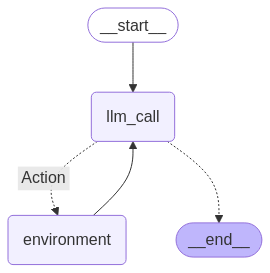

In [4]:
from datetime import datetime
from typing import Literal
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import MessagesState, START, END, StateGraph

# Nodes
def llm_call(state: MessagesState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=SYSTEM_PROMPT.format(
                            image_url=config["configurable"].get("image_url", None),
                            time=datetime.now()
                        )
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke({"args": tool_call["args"], "id": tool_call["id"], "type": "tool_call"})        
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [56]:
config = {
    "configurable": {
        "image_url": None,
    }
}

messages = [HumanMessage(content="What is magic_function(3)?")]
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is magic_function(3)?
================================== Ai Message ==================================
Tool Calls:
  magic_function (call_v5a3)
 Call ID: call_v5a3
  Args:
    input: 3
================================= Tool Message =================================

content='5' name='magic_function' tool_call_id='call_v5a3'
================================== Ai Message ==================================

The result of magic_function(3) is 5.


In [57]:
messages = [HumanMessage(content="What is the weather in SF?")]
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_hm9p)
 Call ID: call_hm9p
  Args:
    query: San Francisco weather
================================= Tool Message =================================

content='[{"title": "Weather in San Francisco", "url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1741747880, \'localtime\': \'2025-03-11 19:51\'}, \'current\': {\'last_updated_epoch\': 1741747500, \'last_updated\': \'2025-03-11 19:45\', \'temp_c\': 13.3, \'temp_f\': 55.9, \'is_day\': 0, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/116.png\', \'code

In [58]:
messages = [HumanMessage(content="Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the mountain behind'")]
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the mountain behind'
================================== Ai Message ==================================
Tool Calls:
  text2image (call_4j6w)
 Call ID: call_4j6w
  Args:
    text: a yellow lab puppy running free with wild flowers in the mountain behind
================================= Tool Message =================================

content='https://replicate.delivery/xezq/TvyRIXJfiS2mbSeQJzM7FCdXlLMcaj6fuQeXOImOCFq7LqeiC/out-0.png' name='text2image' tool_call_id='call_4j6w'
================================== Ai Message ==================================
Tool Calls:
  image2text (call_dyn7)
 Call ID: call_dyn7
  Args:
    image_url: https://replicate.delivery/xezq/TvyRIXJfiS2mbSeQJzM7FCdXlLMcaj6fuQeXOImOCFq7LqeiC/out-0.png
    prompt: a yellow lab puppy running free with wild flowers in the mountain behind
=========

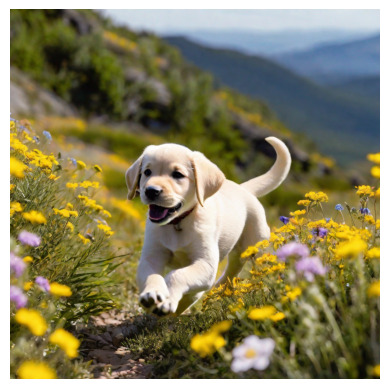

In [61]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(image_url):
    """Display generated image"""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))  
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image("https://replicate.delivery/xezq/TvyRIXJfiS2mbSeQJzM7FCdXlLMcaj6fuQeXOImOCFq7LqeiC/out-0.png")

In [60]:
config = {
    "configurable": {
        "image_url": "https://replicate.delivery/xezq/TvyRIXJfiS2mbSeQJzM7FCdXlLMcaj6fuQeXOImOCFq7LqeiC/out-0.png",
    }
}

messages = [HumanMessage(content="Tell me a story about this image")]
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Tell me a story about this image
================================== Ai Message ==================================
Tool Calls:
  image2text (call_spz8)
 Call ID: call_spz8
  Args:
    image_url: https://replicate.delivery/xezq/TvyRIXJfiS2mbSeQJzM7FCdXlLMcaj6fuQeXOImOCFq7LqeiC/out-0.png
    prompt: Tell me a story about this image
================================= Tool Message =================================

content="In the image, a small white dog is happily running through a field of wildflowers, with its tongue out, enjoying the beautiful scenery. The dog appears to be in a playful mood, as it runs through the colorful flowers, which are scattered all around the field. The scene is set in a mountainous area, adding to the picturesque atmosphere. The dog's joyful expression and the vibrant flowers create a lively and cheerful scene, capturing the essence of nature and the simple pleasures of life." nam

In [62]:
from IPython.display import Audio

def play_audio(output_url):
    return Audio(url=output_url, autoplay=False)

play_audio("https://replicate.delivery/xezq/Y2IIteG2q3UCPi1RLgPeI8fE6D6H6qxogFsgjvVVGXsWVVvoA/out.wav")